### Random Forests Example 2.1
First we generate training and test data by splitting the original data set and define the control variables of the **tree**-package in order to guarantee large trees. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('./data/Heart.csv')

# Replace Categorical Variable with dummies
df = pd.get_dummies(data=df, columns=['AHD'], drop_first=True)
df['ChestPain'], ChestPain_codes = pd.factorize(df['ChestPain'])
df['Thal'], Thal_codes = pd.factorize(df['Thal'])
# Drop NA rows:
df.dropna(inplace=True)
df.reset_index(inplace=True)

# Split in train/test 
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['AHD_Yes']), df['AHD_Yes'], 
    test_size=1/5, random_state=42)

# Tree controlls for large tree
tree_settings = {'criterion': 'entropy',
                 'min_samples_split': 2,
                 'min_samples_leaf': 1,
                 'min_impurity_decrease': 1e-10 ,
                 'random_state': 1}

Now we are ready to perform the bagging procedure. 

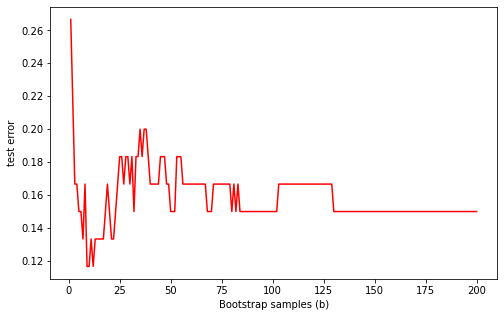

In [2]:
from sklearn import tree
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Number of Bootstrap samples
B = 200
# Number of datapoints in each sample
n_train = X_train.shape[0]

# Empty DataFrames
cur_pred = pd.DataFrame(data=np.zeros((B, X_test.shape[0]))) * np.nan
pred = cur_pred.copy()

# Bootstrap loop
for b in range(B):
    # Resample train data
    samp_X, samp_y = resample(X_train, y_train, n_samples=n_train, 
                              random_state=b)
    # Grow and fit tree
    cur_tree = tree.DecisionTreeClassifier().set_params(**tree_settings)
    cur_tree.fit(samp_X, samp_y)
    
    # Add current prediction of test data
    cur_pred.loc[b, :] = cur_tree.predict(X_test)
    # update prediction with Majority vote
    pred.loc[b, :] = cur_pred.mode().iloc[0, :]

# Test error
e_test = np.mean(abs(pred - y_test.reset_index(drop=True)), axis=1)

# display results
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
plt.plot(np.arange(1, B+1), e_test, 'r-', label='Test error')
ax.set_xlabel('Bootstrap samples (b)')
ax.set_ylabel('test error')

plt.show()

### Random Forests Example 2.2
We compute the OOB error estimate for the **heart** data. Again, we perform the computations explicitly and we will discuss a more convenient computation by means of the **RandomForestClassifier()**-function later. We use the same number $B = 200$ of bootstrap samples as above, however there is no need of a training or test set, such that we redefine the initializations

In [4]:
# Redifine x and y (no split)
X = df.drop(columns=['AHD_Yes'])
y = df['AHD_Yes']

# Number of datapoints in each sample
n = X.shape[0]

e_oob = []
pred = pd.Series(data=np.zeros(n)) * np.nan
cur_pred = pd.DataFrame(data=np.zeros((B, n))) * np.nan

The variable **cur\_pred** contains $B$ rows and $n$ predictions. Each entry will only contain the out-of-bag samples and otherwise nan. The variable **pred** will contain a Series of length $n$ which contains the *latest* majority vote. The OOB-error is then calculated using **pred** and the true class.

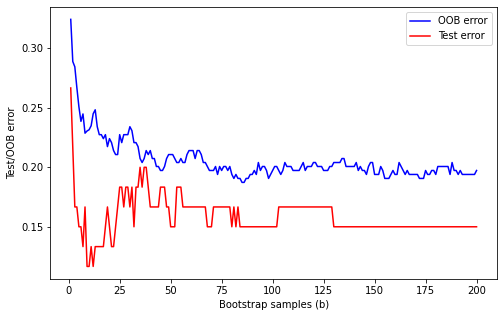

In [5]:
# Bootstrap loop
for b in range(B):
    # Resample train data
    samp_X, samp_y = resample(X, y, n_samples=n, 
                              random_state=b)
    # Store index OOB samples:
    mask = np.isin(X.index, samp_X.index, invert=True)
    i_oob = X.index[mask]
    # Grow and fit tree
    cur_tree = tree.DecisionTreeClassifier().set_params(**tree_settings)
    cur_tree.fit(samp_X, samp_y)
    
    # Add current prediction of oob data
    cur_pred.loc[b, i_oob] = cur_tree.predict(X.loc[i_oob, :])
    # update prediction with Majority vote
    pred.loc[i_oob] = cur_pred.loc[:, i_oob].mode().iloc[0, :]
    
    # Calculate OOB error over all oob samples
    cur_e_oob = np.mean(abs(pred - y))
    e_oob.append(cur_e_oob)

# display results
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(1, 1, 1)
plt.plot(np.arange(1, B+1), e_oob, 'b-', label='OOB error')
plt.plot(np.arange(1, B+1), e_test, 'r-', label='Test error')

ax.set_xlabel('Bootstrap samples (b)')
ax.set_ylabel('Test/OOB error')
plt.legend()

plt.show()

As it can be seen, the OOB-error approximates the test error fairly well; without the need of a test set, though. 